In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from helpers import *
from matplotlib import pyplot as plt
import numpy as np
from experiment_constant import *
from experiment_train import *
import pandas as pd
import seaborn as sns
from keras.datasets import boston_housing

Using TensorFlow backend.


Initialized TensorFlow


In [2]:
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()
dataset = (x_train, y_train, x_test, y_test)

### Fixed single random experiment for many random points

In [3]:
# pfailure for the first layer
p = 1e-2

In [4]:
# run with random weights and multiple inputs
exp = TrainExperiment(*dataset, [50, 50], [p, 0], epochs = 20, activation = 'relu', do_print = True)

NameError: name 'classify' is not defined

In [27]:
exp.get_mae_nocrash()

(9.267826375414778, 9.397748231017006)

100%|██████████| 50/50 [00:03<00:00, 13.34it/s]


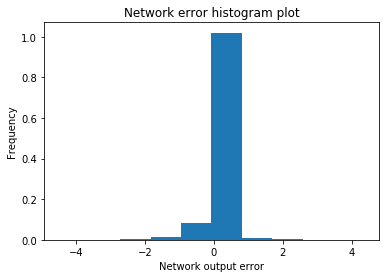

Absolute Error; average over inputs, average over dropout:
True values array mean: 1.241085 std 2.173228
Bound L1Prod  3.392926
Bound L2Prod  0.362741
Bound L1Sum   22.811138
Bound L2Sum   8.375686
Bound FSum    21.862720
Bound v1      1.573295 Std 3.180068
Bound v2      0.754070
Bound v3 app  0.196471
Bound v3 exct 0.073671 Std 0.475343
Bound v3 bttr 0.104061 Std 0.477724
Experiment    0.168355 Std 0.457175
MeanAct [0.507624 0.522648]


In [11]:
# inputs to test
data = np.random.randn(50, 13) * 2

# obtaining data
r = exp.run(inputs = data, repetitions = 10000)

Only have v3_approx and v3_exact which support individual input vectors

In [12]:
# looking at output shapes
shapes = [[key, np.array(value).shape] for key, value in r.items()]
print('Shapes of experiment outputs')
pd.DataFrame(shapes, columns = ['name', 'shape'])

Shapes of experiment outputs


,name,shape
0,input,"(50, 13)"
1,activations,"(50, 2)"
2,output,"(50, 1)"
3,error_exp_mean,"(50, 1)"
4,error_exp_std,"(50, 1)"
5,error_abs_exp_mean,"(50, 1)"
6,error_abs_exp_std,"(50, 1)"
7,error_v1_mean,()
8,error_v1_std,()
9,error_v2_mean,"(1,)"


Mean bound


,value,Correlation,Rank Loss
0,error_v3_mean_better,0.996183,0.018776
1,error_v3_mean_exact,0.849315,0.182857
2,error_v3_mean_approx,0.364871,0.378776


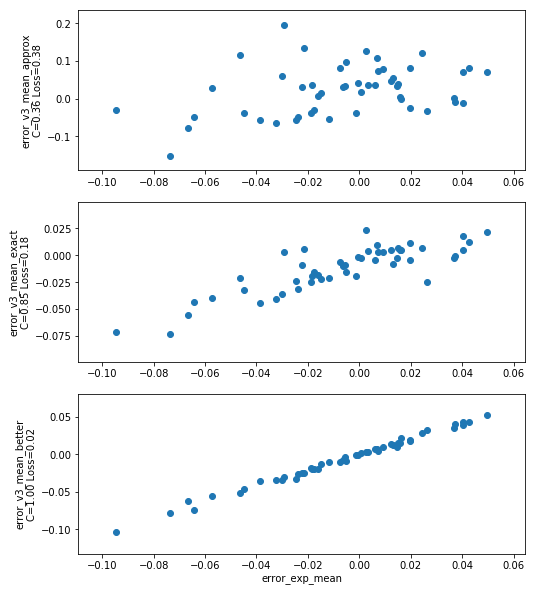

In [13]:
# experimental error
main_key = 'error_exp_mean'

# theoretical bounds
other_keys = ['error_v3_mean_exact', 'error_v3_mean_approx', 'error_v3_mean_better']

# all values
all_keys = [main_key] + other_keys

# dataframe
data = pd.DataFrame({key: r[key].flatten() for key in all_keys})

# correlation
corr = data.corr()[main_key]

# rank loss
loss = {x: min(y, 1 - y) for x, y in compute_rank_losses(data, main_key).items()}

# sorting by corr. coeff
other_keys = sorted(other_keys, key = lambda key: np.abs(corr[key]))

print('Mean bound')

# plotting scatter plots with experimental mean
fig, axs = plt.subplots(3, 1, figsize=(8, 10))
axs = axs.ravel()
for i, key in enumerate(other_keys):
    #axs[i].set_title()
    if i + 1 == len(other_keys):
        axs[i].set_xlabel(main_key)
    axs[i].set_ylabel(key + '\nC=%.2f Loss=%.2f' % (corr[key], loss[key]))
    axs[i].scatter(data[main_key], data[key] * np.sign(corr[key]))

# List the best bounds
pd.DataFrame([(key, corr[key], loss[key]) for key in other_keys[::-1]], columns = ['value', 'Correlation', 'Rank Loss'])

Std bound


,value,Correlation,Rank Loss
0,error_v3_std_better,0.996741,0.027755
1,error_v3_std_exact,0.898999,0.130612
2,error_v3_std_square,0.838478,0.163265


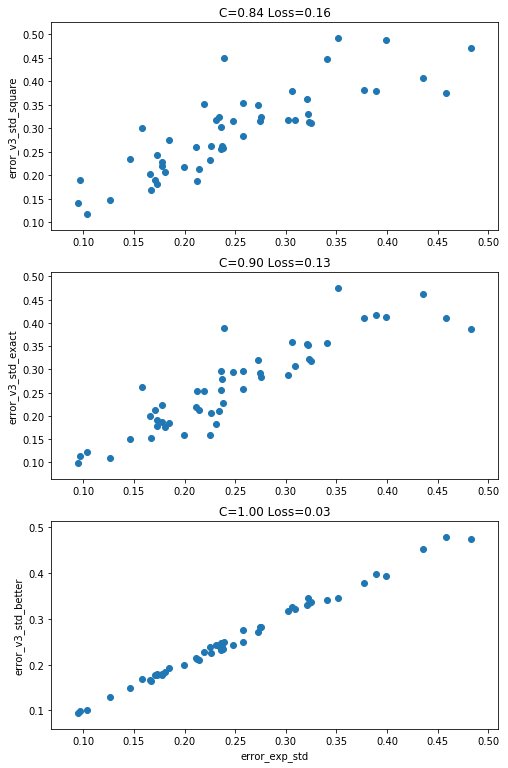

In [14]:
# experimental error
main_key = 'error_exp_std'

# theoretical bounds
other_keys = ['error_v3_std_exact', 'error_v3_std_square', 'error_v3_std_better']

# all values
all_keys = [main_key] + other_keys

# dataframe
data = pd.DataFrame({key: r[key].flatten() for key in all_keys})

# correlation
corr = data.corr()[main_key]

# rank loss
loss = {x: min(y, 1 - y) for x, y in compute_rank_losses(data, main_key).items()}

# sorting by corr. coeff
other_keys = sorted(other_keys, key = lambda key: np.abs(corr[key]))

print('Std bound')

# plotting scatter plots with experimental mean
fig, axs = plt.subplots(3, 1, figsize=(8, 13))
axs = axs.ravel()
for i, key in enumerate(other_keys):
    axs[i].set_title('C=%.2f Loss=%.2f' % (corr[key], loss[key]))
    if i + 1 == len(other_keys):
        axs[i].set_xlabel(main_key)
    axs[i].set_ylabel(key)
    axs[i].scatter(data[main_key], data[key] * np.sign(corr[key]))
    
# List the best bounds
pd.DataFrame([(key, corr[key], loss[key]) for key in other_keys[::-1]], columns = ['value', 'Correlation', 'Rank Loss'])

See that there's correlation of approximately 0.999... between theory (v3.exact and v3.better) and practive (experiment, mean over repetitions). Same is not true for the approximate bound which gives somethins about 0.90. Again, exact bound is better in rank loss. Squared version of the variance bound also doesn't work

### Comparing random networks on a fixed input

In [9]:
# pfailure for the first layer
p = 1e-2

# input to test
data = np.random.randn(1, 50) * 2 + 0.1

In [10]:
# array with networks
results = []

# looking at 50 random networks
for i in tqdm(range(100)):
    # run with random weights and multiple inputs
    exp = RandomExperiment([50, 50, 50, 1], [p, 0], 1, activation = 'relu', std_weight = 3, mean_weight = 0.1)

    # obtaining data
    r = exp.run(inputs = data, repetitions = 10000, do_plot = False, do_tqdm = False, do_print = False)
    
    # adding to results
    results += [r]
    
    # removing the model
    K.clear_session()

100%|██████████| 100/100 [01:32<00:00,  1.07it/s]


Mean bound


,value,Correlation,Rank Loss
0,error_v3_mean_better,0.991719,0.036970
1,error_v3_mean_exact,0.991719,0.036970
2,error_v2_mean,-0.978604,0.067879
3,error_v3_mean_approx,0.971257,0.081010
4,error_matnorm_prod_l2,-0.910180,0.138586
5,error_matnorm_prod_l1,-0.727927,0.227879
6,error_matnorm_sum_l1,-0.550393,0.311515
7,error_v1_mean,-0.533051,0.311515
8,error_matnorm_sum_F,-0.428034,0.354545
9,error_matnorm_sum_l2,-0.404380,0.364040


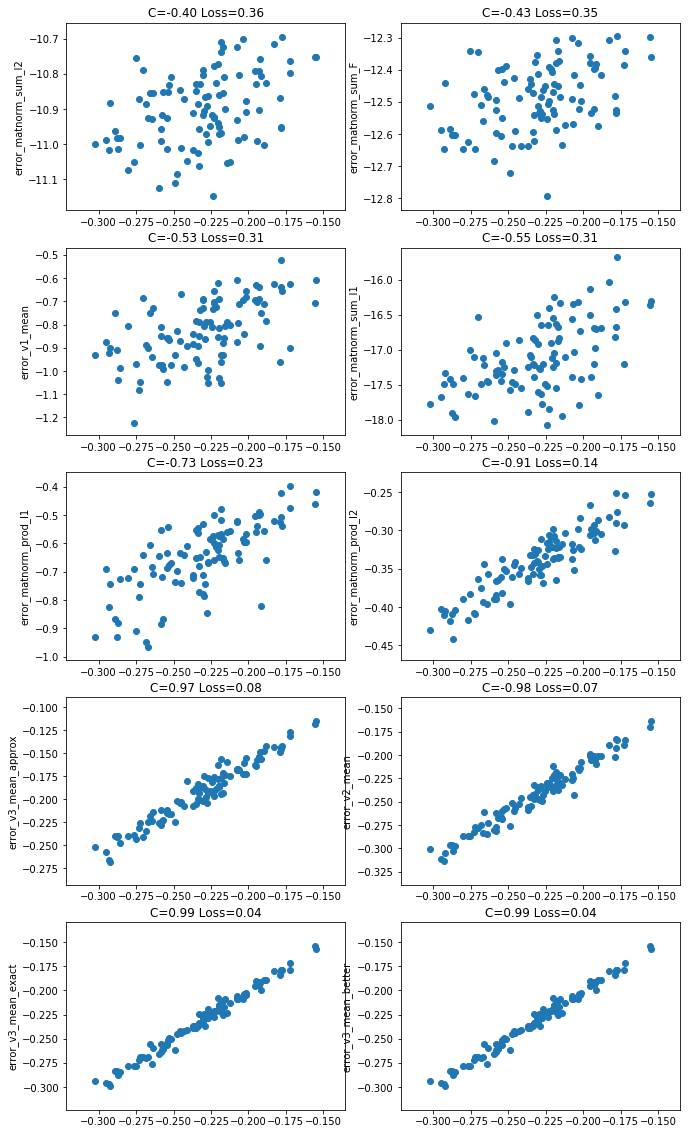

In [11]:
# creating a dataframe with mean bounds
data = {}

# loop over networks
for net in results:
    for key, value in net.items():
        if key not in data: data[key] = []
        data[key] += [np.mean(value)]

# removing extra columns
del data['input']
del data['error_abs_exp_mean']
del data['output']
del data['activations']

# removing columns on variance
for col in list(data.keys()):
    if col.find('std') >= 0:
        del data[col]

# converting to df
data = pd.DataFrame(data)

# plotting scatter plots with experimental mean
main_key = 'error_exp_mean'

# correlation
corr = data.corr()[main_key]

# rank loss
loss = {x: min(y, 1 - y) for x, y in compute_rank_losses(data, main_key).items()}

# sorting keys by abs. correlation
other_keys = [key for key in data.keys() if key != main_key]
other_keys = sorted(other_keys, key = lambda key: np.abs(corr[key]))

print('Mean bound')

# plotting
fig, axs = plt.subplots(5, 2, figsize=(11, 20))
axs = axs.ravel()
for i, key in enumerate(other_keys):
    axs[i].set_title('C=%.2f Loss=%.2f' % (corr[key], loss[key]))
    #axs[i].set_xlabel(main_key)
    axs[i].set_ylabel(key)
    axs[i].scatter(data[main_key], data[key] * np.sign(corr[key]))

# List the best bounds
pd.DataFrame([(key, corr[key], loss[key]) for key in other_keys[::-1]], columns = ['value', 'Correlation', 'Rank Loss'])

Std bound


,value,Correlation,Rank Loss
0,error_v3_std_better,0.994193,0.032929
1,error_v3_std_exact,0.994193,0.032929
2,error_v3_std_square,0.964032,0.085859
3,error_matnorm_prod_l2,0.952918,0.099394
4,error_matnorm_prod_l1,0.694291,0.252929
5,error_v1_std,0.651862,0.265051
6,error_matnorm_sum_l1,0.616731,0.285253
7,error_matnorm_sum_F,0.491897,0.334343
8,error_matnorm_sum_l2,0.438017,0.353939


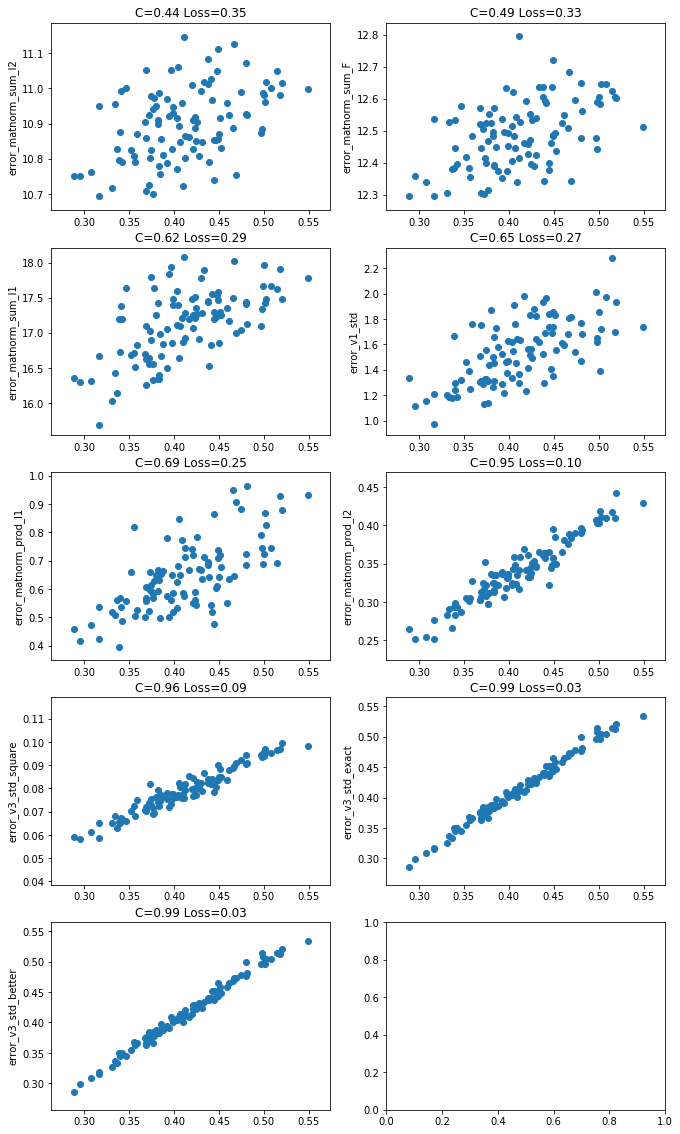

In [12]:
# creating a dataframe with mean bounds
data = {}

# loop over networks
for net in results:
    for key, value in net.items():
        if key not in data: data[key] = []
        data[key] += [np.mean(value)]

# removing extra columns
del data['input']
del data['error_abs_exp_std']
del data['output']
del data['activations']

# removing columns on variance
for col in list(data.keys()):
    if col.find('mean') >= 0:
        del data[col]

# converting to df
data = pd.DataFrame(data)

# plotting scatter plots with experimental mean
main_key = 'error_exp_std'

# correlation
corr = data.corr()[main_key]

# rank loss
loss = {x: min(y, 1 - y) for x, y in compute_rank_losses(data, main_key).items()}

# sorting keys by abs. correlation
other_keys = [key for key in data.keys() if key != main_key]
other_keys = sorted(other_keys, key = lambda key: np.abs(corr[key]))

print('Std bound')

# plotting
fig, axs = plt.subplots(5, 2, figsize=(11, 20))
axs = axs.ravel()
for i, key in enumerate(other_keys):
    axs[i].set_title('C=%.2f Loss=%.2f' % (corr[key], loss[key]))
    #axs[i].set_xlabel(main_key)
    axs[i].set_ylabel(key)
    axs[i].scatter(data[main_key], data[key] * np.sign(corr[key]))

# List the best bounds
pd.DataFrame([(key, corr[key], loss[key]) for key in other_keys[::-1]], columns = ['value', 'Correlation', 'Rank Loss'])